In [ ]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3


In [ ]:
#mounting a folder
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/data

Mounted at /content/drive
Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


In [ ]:
dir_list = os.listdir('/content/drive/My Drive/data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/drive/My Drive/data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = '/content/drive/My Drive/data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [ ]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,1,1
1,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,0,1,1
2,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,0,2
3,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,1,2
4,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,0,1


In [ ]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/My Drive/data/Actor_18/03-01-02-01-02-01-18.wav


(22050, array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.6953952e-09, -3.3706307e-09,  0.0000000e+00], dtype=float32))

In [ ]:
len(samples), sample_rate

(80196, 22050)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
sample_rate/ len(samples)

0.2749513691455933

Text(0.5, 0, 'Seconds')

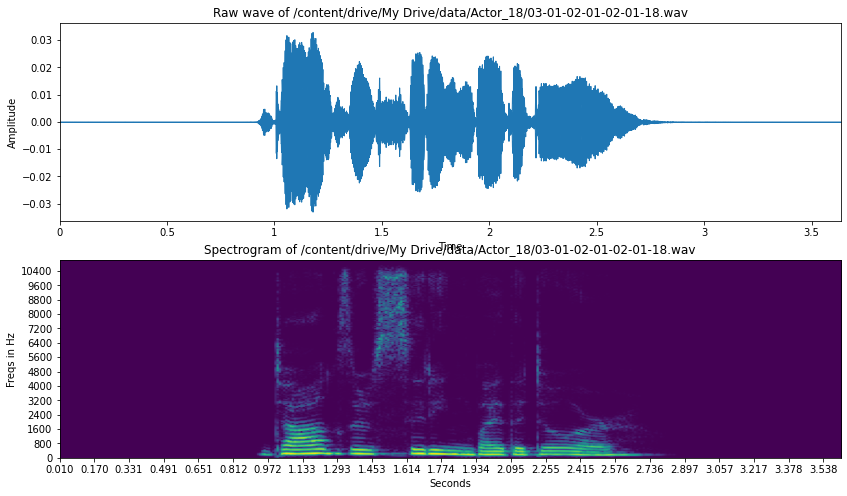

In [ ]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [ ]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-4.5053457e-05, -4.6858717e-05, -4.3048098e-05, ...,
        -5.1633379e-04, -4.8599389e-04, -4.8891839e-04], dtype=float32),
 array([19968, 60416]))

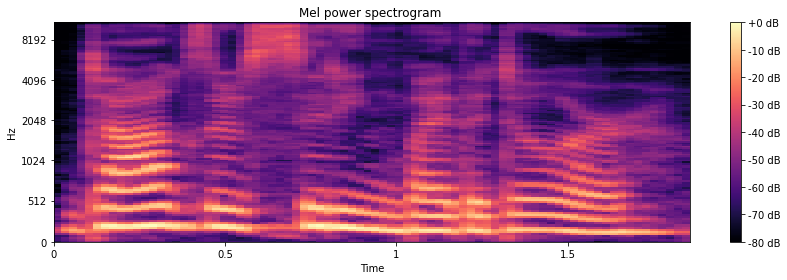

In [ ]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

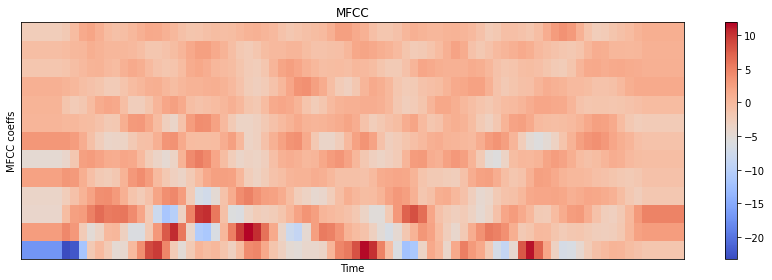

In [ ]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [ ]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_scared"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [ ]:
# Select the label set you want by commenting the unwanteds.
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,1,1,male_neutral
1,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,0,1,1,male_neutral
2,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,0,2,male_calm
3,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,1,2,male_calm
4,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,0,1,male_neutral


In [ ]:
print (data_df.label.value_counts().keys())

Index(['female_scared', 'male_scared', 'female_surprised', 'female_calm',
       'male_calm', 'male_angry', 'female_angry', 'female_happy', 'male_sad',
       'female_disgust', 'male_surprised', 'male_disgust', 'male_happy',
       'female_sad', 'male_neutral', 'female_neutral'],
      dtype='object')


In [ ]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

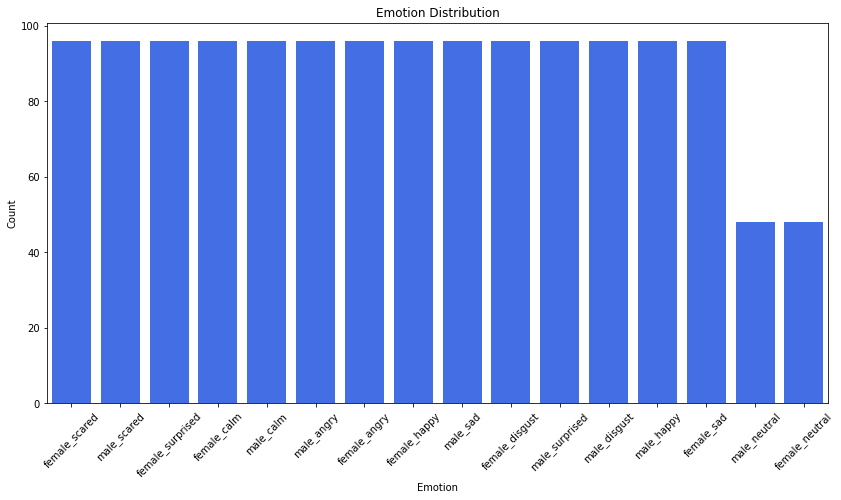

In [ ]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [ ]:
data2_df = data_df.copy()
tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 23]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,1,1,male_neutral
1,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,0,1,1,male_neutral
2,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,0,2,male_calm
3,/content/drive/My Drive/data/Actor_01/03-01-02...,1,1,male,0,0,1,2,male_calm
4,/content/drive/My Drive/data/Actor_01/03-01-01...,1,1,male,0,1,0,1,male_neutral


In [ ]:
print (len(data3_df))
data3_df.head()

120


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/My Drive/data/Actor_21/03-01-01...,1,21,male,0,0,1,1,male_neutral
1,/content/drive/My Drive/data/Actor_21/03-01-01...,1,21,male,0,0,0,1,male_neutral
2,/content/drive/My Drive/data/Actor_21/03-01-01...,1,21,male,0,1,0,1,male_neutral
3,/content/drive/My Drive/data/Actor_21/03-01-05...,1,21,male,0,0,1,5,male_angry
4,/content/drive/My Drive/data/Actor_21/03-01-02...,1,21,male,0,1,0,2,male_calm


In [ ]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1440/1440 [13:35<00:00,  1.77it/s]


In [ ]:
data.head()

,feature
0,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
3,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."
4,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.682144,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.750832,-63.380207,-62.699947,-65.097626,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.002151,-61.924175,-59.584446,-56.339230,-54.955643,-55.590595,...,-60.836159,-60.906948,-61.827415,-65.505867,-64.025543,-60.703037,-58.082230,-59.942570,-63.323788,-64.604362,-66.057564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-63.679653,-59.562466,-59.068306,-62.143024,-62.431461,-64.841820,-65.389946,-65.389946,-63.869839,-61.360493,-59.707012,-59.798038,-62.271156,-60.549892,-58.221012,-58.358536,-60.648369,-53.253780,-51.222225,-49.679050,-51.875679,-56.024105,-57.659172,-58.432064,-58.607403,-60.929775,-64.418907,-58.209209,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-64.167854,-63.399307,-65.389946,-65.389946,-65.389946,-64.832314,-62.786911,-65.027260,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.000664,-69.980827,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-66.096390,-63.397282,-68.259895,-70.267769,-69.665245,-68.817131,-66.114662,-63.901035,-68.620621,-70.267769,-69.641991,-68.420158,-70.044182,-67.232468,-66.350388,-68.503464,-66.577591,-62.980961,-62.693489,-65.906677,...,-61.326134,-60.893414,-63.767982,-62.977470,-61.404842,-63.950096,-65.938507,-69.175484,-61.678368,-61.514542,-66.917595,-69.971886,-70.267769,-70.267769,-69.274994,-69.495430,-70.267769,-70.102097,-70.267769,-69.902893,-70.267769,-69.916420,-69.471649,-68.002296,-67.983574,-70.267769,-70.267769,-68.205635,-64.099167,-67.300316,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.207008,-63.987667,-63.159420,-65.259773,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.524406,-61.292175,-57.662598,...,-60.530327,-65.795273,-66.635185,-67.428696,-65.402657,-61.771988,-61.545261,-62.659328,-66.034683,-66.366577,-66.321747,-67.027756,-67.557388,-67.111320,-66.606255,-67.557388,-67.557388,-67.557388,-67.175430,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388
4,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,-65.818863,-65.818863,-65.818863,-65.108398,-65.818863,-65.818863,-65.818863,-65.261421,-65.123924,-65.818863,-64.191040,-61.744362,-61.067486,-61.839817,-65.328690,-65.211166,-65.663170,-65.818863,-65.818863,-65.816132,-65.818863,-65.818863,-65.818863,-65.818863,-65.818863,-65.470490,-62.254330,-59.888401,-62.292805,-60.520290,...,-65.818863,-65.818863,-65.818863,-65

In [ ]:
newdf = pd.concat([df3,labels], axis=1)

In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
print(len(rnewdf))
rnewdf.head(10)

1440


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.682144,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.750832,-63.380207,-62.699947,-65.097626,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.002151,-61.924175,-59.584446,-56.339230,-54.955643,-55.590595,...,-60.906948,-61.827415,-65.505867,-64.025543,-60.703037,-58.082230,-59.942570,-63.323788,-64.604362,-66.057564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-63.679653,-59.562466,-59.068306,-62.143024,-62.431461,-64.841820,-65.389946,-65.389946,-63.869839,-61.360493,-59.707012,-59.798038,-62.271156,-60.549892,-58.221012,-58.358536,-60.648369,-53.253780,-51.222225,-49.679050,-51.875679,-56.024105,-57.659172,-58.432064,-58.607403,-60.929775,-64.418907,-58.209209,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-64.167854,-63.399307,-65.389946,-65.389946,-65.389946,-64.832314,-62.786911,-65.027260,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.000664,-69.980827,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-66.096390,-63.397282,-68.259895,-70.267769,-69.665245,-68.817131,-66.114662,-63.901035,-68.620621,-70.267769,-69.641991,-68.420158,-70.044182,-67.232468,-66.350388,-68.503464,-66.577591,-62.980961,-62.693489,-65.906677,...,-60.893414,-63.767982,-62.977470,-61.404842,-63.950096,-65.938507,-69.175484,-61.678368,-61.514542,-66.917595,-69.971886,-70.267769,-70.267769,-69.274994,-69.495430,-70.267769,-70.102097,-70.267769,-69.902893,-70.267769,-69.916420,-69.471649,-68.002296,-67.983574,-70.267769,-70.267769,-68.205635,-64.099167,-67.300316,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.207008,-63.987667,-63.159420,-65.259773,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.524406,-61.292175,-57.662598,...,-65.795273,-66.635185,-67.428696,-65.402657,-61.771988,-61.545261,-62.659328,-66.034683,-66.366577,-66.321747,-67.027756,-67.557388,-67.111320,-66.606255,-67.557388,-67.557388,-67.557388,-67.175430,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_calm
4,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,-65.818863,-65.818863,-65.818863,-65.108398,-65.818863,-65.818863,-65.818863,-65.261421,-65.123924,-65.818863,-64.191040,-61.744362,-61.067486,-61.839817,-65.328690,-65.211166,-65.663170,-65.818863,-65.818863,-65.816132,-65.818863,-65.818863,-65.818863,-65.818863,-65.818863,-65.470490,-62.254330,-59.888401,-62.292805,-60.520290,...,-65.818863,-65.818863,-65.818863

In [ ]:
rnewdf.isnull().sum().sum()

5708

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.682144,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.750832,-63.380207,-62.699947,-65.097626,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.002151,-61.924175,-59.584446,-56.339230,-54.955643,-55.590595,...,-60.906948,-61.827415,-65.505867,-64.025543,-60.703037,-58.082230,-59.942570,-63.323788,-64.604362,-66.057564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-63.679653,-59.562466,-59.068306,-62.143024,-62.431461,-64.841820,-65.389946,-65.389946,-63.869839,-61.360493,-59.707012,-59.798038,-62.271156,-60.549892,-58.221012,-58.358536,-60.648369,-53.253780,-51.222225,-49.679050,-51.875679,-56.024105,-57.659172,-58.432064,-58.607403,-60.929775,-64.418907,-58.209209,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-64.167854,-63.399307,-65.389946,-65.389946,-65.389946,-64.832314,-62.786911,-65.027260,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.000664,-69.980827,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-66.096390,-63.397282,-68.259895,-70.267769,-69.665245,-68.817131,-66.114662,-63.901035,-68.620621,-70.267769,-69.641991,-68.420158,-70.044182,-67.232468,-66.350388,-68.503464,-66.577591,-62.980961,-62.693489,-65.906677,...,-60.893414,-63.767982,-62.977470,-61.404842,-63.950096,-65.938507,-69.175484,-61.678368,-61.514542,-66.917595,-69.971886,-70.267769,-70.267769,-69.274994,-69.495430,-70.267769,-70.102097,-70.267769,-69.902893,-70.267769,-69.916420,-69.471649,-68.002296,-67.983574,-70.267769,-70.267769,-68.205635,-64.099167,-67.300316,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.207008,-63.987667,-63.159420,-65.259773,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.524406,-61.292175,-57.662598,...,-65.795273,-66.635185,-67.428696,-65.402657,-61.771988,-61.545261,-62.659328,-66.034683,-66.366577,-66.321747,-67.027756,-67.557388,-67.111320,-66.606255,-67.557388,-67.557388,-67.557388,-67.175430,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_calm
4,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,-65.818863,-65.818863,-65.818863,-65.108398,-65.818863,-65.818863,-65.818863,-65.261421,-65.123924,-65.818863,-64.191040,-61.744362,-61.067486,-61.8398

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

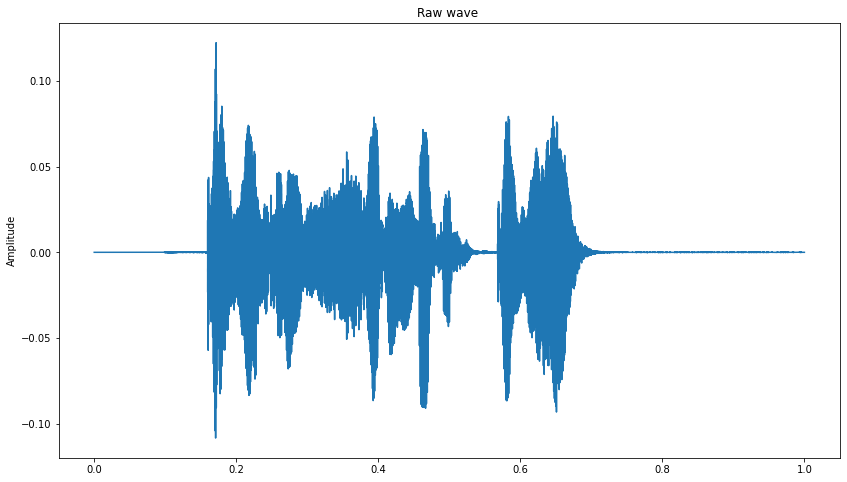

In [ ]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

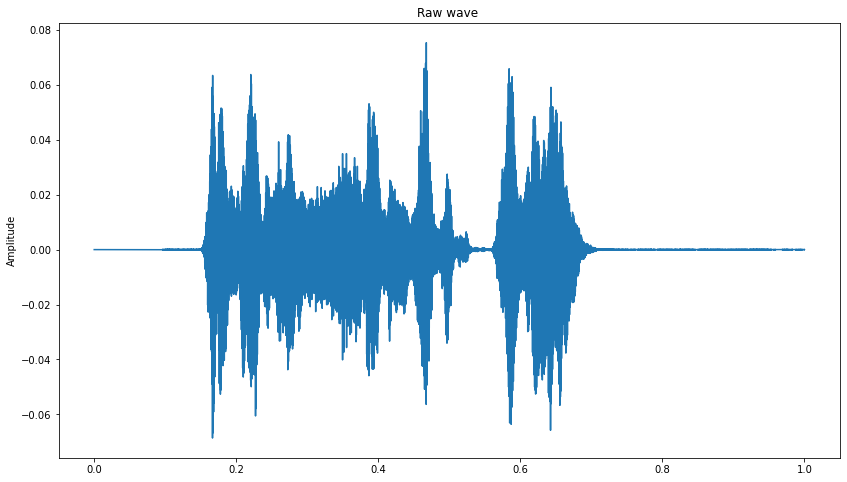

In [ ]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [ ]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 1440/1440 [02:22<00:00, 10.09it/s]


In [ ]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
len(syn_data1), len(syn_data2) 

100%|██████████| 1440/1440 [08:29<00:00,  2.83it/s]


(1440, 1440)

In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1440

In [ ]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-65.642915,-65.202375,-65.938109,-65.333506,-65.682872,-65.363568,-64.707801,-65.747459,-65.867630,-65.407547,-65.284035,-65.157173,-65.617224,-65.126822,-64.855292,-64.956352,-65.053021,-64.813543,-63.647466,-65.154181,-65.253904,-63.213850,-61.277441,-61.153056,-63.046078,-65.053621,-65.245132,-65.090244,-65.082392,-65.007458,-64.932454,-65.156834,-65.245368,-65.803173,-64.429478,-61.552594,-59.822216,-56.118082,-54.907677,-55.650900,...,-60.593103,-62.130260,-65.020727,-62.526596,-59.574717,-58.199867,-59.364263,-61.463560,-62.139509,-63.722316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-62.284568,-62.444511,-61.952757,-58.515254,-59.061565,-61.272918,-62.813278,-64.807118,-63.588220,-62.105080,-63.074583,-63.645128,-63.010142,-59.019295,-59.028831,-60.786442,-61.857921,-61.504110,-63.021316,-63.624329,-61.935715,-60.311280,-58.653025,-59.030157,-59.989577,-58.080835,-56.319558,-56.393489,-60.086498,-52.616570,-50.472662,-49.343577,-51.860647,-54.443757,-55.240475,-56.718401,-57.828236,-59.475393,-61.877453,-56.814448,...,-63.851529,-64.321152,-63.080612,-62.136912,-63.179925,-62.181946,-62.340127,-62.290484,-62.938732,-62.684207,-63.207025,-63.157738,-63.202470,-61.776925,-60.642156,-62.323385,-62.651014,-62.616186,-64.272828,-62.810730,-62.108141,-63.309363,-64.390411,-63.038397,-62.101560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-58.686449,-60.863789,-64.494722,-64.518370,-64.577237,-61.324826,-59.763642,-60.120539,-60.686970,-61.184997,-60.861023,-60.176192,-59.723145,-61.744087,-62.098098,-60.774613,-60.255558,-59.373813,-59.952480,-62.075660,-61.164440,-60.194066,-60.223281,-61.653140,-62.197731,-64.007387,-61.797960,-60.335766,-60.306069,-62.148474,-65.016459,-61.850398,-59.413797,-57.975502,-58.432780,-60.015694,-60.638311,-59.837778,-58.095030,-58.728900,...,-57.797677,-59.420060,-59.722835,-58.064388,-60.192181,-60.055323,-58.359526,-57.398680,-57.075602,-58.460225,-59.411596,-59.641231,-61.233759,-62.553395,-62.320171,-60.603892,-60.428040,-60.390399,-62.566873,-61.184621,-60.237188,-60.867647,-61.576905,-61.573723,-64.208813,-62.331921,-60.855338,-58.376931,-60.293251,-62.324478,-60.955497,-60.589299,-59.979717,-58.970245,-59.608160,-63.062800,-62.775159,-61.068922,-60.130239,male_calm
3,-59.385614,-56.225202,-55.017966,-56.891674,-56.860419,-57.080438,-56.958328,-53.929280,-52.474846,-53.779438,-54.149145,-55.774705,-57.353798,-58.578867,-57.942108,-58.735027,-56.704741,-55.282500,-57.537157,-58.672241,-56.586041,-54.712148,-54.151307,-54.128615,-55.221810,-56.356435,-58.075415,-57.233912,-56.772728,-57.132628,-56.281364,-57.687472,-59.104898,-57.902018,-56.669439,-56.322497,-54.145141,-54.935927,-54.710849,-52.901191,...,-60.250443,-59.137459,-59.393779,-58.519466,-55.419953,-55.549809,-55.779917,-56.157530,-57.009252,-57.972062,-59.820617,-56.556258,-55.592681,-54.932446,-55.774754,-56.118890,-55.829423,-56.981233,-57.662129,-56.202318,-56.349711,-56.729316,-58.629384,-58.918132,-55.213409,-56.542048,-57.982755,-56.906204,-57.746897,-59.275779,-55.623958,-55.271845,-56.997816,-55.413680,-56.110912,-57.797834,-56.498978,-55.731268,-55.190638,male_calm
4,-61.519550,-61.936472,-63.080515,-62.583003,-59.741606,-60.188695,-64.888094,-63.808286,-60.167223,-60.223052,-62.394911,-62.941033,-60.944821,-61.261796,-61.139641,-60.675091,-60.972017,-61.919610,-61.242477,-61.077102,-59.773532,-58.203864,-58.221857,-59.6529

In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1440

In [ ]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.532851,-66.593635,-63.540069,-60.358168,-58.479500,-57.918273,-57.469011,...,-62.952256,-64.316440,-65.722908,-63.755217,-61.968307,-61.905160,-63.087876,-64.332925,-66.049650,-66.532851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-62.342065,-63.951733,-65.587779,-64.284813,-64.238948,-65.785292,-67.332256,-68.443079,-68.443079,-68.443079,-68.443079,-67.511126,-65.247873,-64.333786,-62.203618,-63.532619,-67.043808,-68.002071,-68.443079,-68.270051,-66.336083,-63.330005,-62.565353,-65.640483,-65.148244,-63.607034,-63.451227,-63.901702,-61.236987,-57.258231,-56.858121,-57.276948,-57.183208,-60.239394,-62.605534,-65.499724,-67.008303,-65.825536,-63.558283,-62.985217,...,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.382821,-67.106630,-66.884778,-68.298773,-68.443079,-68.442367,-67.677677,-66.994195,-67.956050,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,-68.443079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.445138,-72.381312,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.544195,-72.221221,-72.516681,-72.544195,-72.544195,-72.446343,-72.561468,-72.457204,-71.263708,-69.747551,-70.237507,-72.258360,-72.550278,-71.931039,-71.719283,-70.883030,-69.700512,-69.609629,-68.721104,-66.017197,-65.795638,-68.411345,...,-66.247971,-65.920421,-67.379633,-67.182739,-67.045350,-68.416257,-69.556094,-67.085360,-66.075197,-67.990745,-71.224350,-72.544195,-72.544195,-72.382523,-72.540315,-72.544195,-72.474607,-72.544195,-72.535337,-72.364974,-72.544195,-72.227017,-71.703482,-71.499026,-72.544195,-72.544195,-69.741108,-68.509982,-70.040829,-72.516502,-72.544195,-72.270031,-72.193759,-72.413974,-72.475324,-72.152721,-72.053495,-72.544195,-72.544195,male_calm
3,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-69.875142,-69.501802,-70.162736,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-68.228103,-65.952433,-66.176588,-68.621034,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.379578,-70.340453,-66.372449,-60.183265,...,-67.241571,-70.139125,-69.385151,-66.671089,-64.492218,-65.385386,-68.222251,-68.146439,-69.338143,-70.139362,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.278921,-70.173079,-70.154824,-70.278921,male_calm
4,-70.019276,-70.019276,-70.019276,-69.857692,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-70.019276,-68.776567,-70.019276,-70.019276,-68.233892,-67.981722,-69.153364,-65.607137,-64.689720,-64.612263,-65.2107

In [ ]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.682144,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-65.750832,-63.380207,-62.699947,-65.097626,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.002151,-61.924175,-59.584446,-56.339230,-54.955643,-55.590595,...,-60.906948,-61.827415,-65.505867,-64.025543,-60.703037,-58.082230,-59.942570,-63.323788,-64.604362,-66.057564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-63.679653,-59.562466,-59.068306,-62.143024,-62.431461,-64.841820,-65.389946,-65.389946,-63.869839,-61.360493,-59.707012,-59.798038,-62.271156,-60.549892,-58.221012,-58.358536,-60.648369,-53.253780,-51.222225,-49.679050,-51.875679,-56.024105,-57.659172,-58.432064,-58.607403,-60.929775,-64.418907,-58.209209,...,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-64.167854,-63.399307,-65.389946,-65.389946,-65.389946,-64.832314,-62.786911,-65.027260,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,-65.389946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.000664,-69.980827,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-66.096390,-63.397282,-68.259895,-70.267769,-69.665245,-68.817131,-66.114662,-63.901035,-68.620621,-70.267769,-69.641991,-68.420158,-70.044182,-67.232468,-66.350388,-68.503464,-66.577591,-62.980961,-62.693489,-65.906677,...,-60.893414,-63.767982,-62.977470,-61.404842,-63.950096,-65.938507,-69.175484,-61.678368,-61.514542,-66.917595,-69.971886,-70.267769,-70.267769,-69.274994,-69.495430,-70.267769,-70.102097,-70.267769,-69.902893,-70.267769,-69.916420,-69.471649,-68.002296,-67.983574,-70.267769,-70.267769,-68.205635,-64.099167,-67.300316,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.207008,-63.987667,-63.159420,-65.259773,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.524406,-61.292175,-57.662598,...,-65.795273,-66.635185,-67.428696,-65.402657,-61.771988,-61.545261,-62.659328,-66.034683,-66.366577,-66.321747,-67.027756,-67.557388,-67.111320,-66.606255,-67.557388,-67.557388,-67.557388,-67.175430,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_calm
4,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,-65.818863,-65.818863,-65.818863,-65.108398,-65.818863,-65.818863,-65.818863,-65.261421,-65.123924,-65.818863,-64.191040,-61.744362,-61.067486,-61.8398

In [ ]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

male_angry          231
female_angry        231
male_disgust        231
male_happy          231
female_scared       231
male_scared         231
female_calm         230
female_disgust      230
female_surprised    230
male_calm           230
female_happy        230
male_sad            230
male_surprised      230
female_sad          230
male_neutral        115
female_neutral      115
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

male_sad            58
female_disgust      58
female_surprised    58
female_calm         58
male_surprised      58
male_calm           58
female_sad          58
female_happy        58
female_scared       57
male_scared         57
male_disgust        57
male_angry          57
male_happy          57
female_angry        57
male_neutral        29
female_neutral      29
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train.shape

(3456, 259)

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
# Setting up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [ ]:
# Plotting Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 259, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 259, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0

In [ ]:
# Compiling model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [ ]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
mcp_save = ModelCheckpoint('/content/drive/My Drive/saved_model/CNN.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=300,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/300
216/216 [==============================] - 37s 31ms/step - loss: 2.8173 - accuracy: 0.0843 - fscore: 0.0000e+00 - val_loss: 2.7332 - val_accuracy: 0.1030 - val_fscore: 0.0000e+00
Epoch 2/300
216/216 [==============================] - 6s 27ms/step - loss: 2.6606 - accuracy: 0.0988 - fscore: 0.0000e+00 - val_loss: 2.6478 - val_accuracy: 0.1794 - val_fscore: 0.0000e+00
Epoch 3/300
216/216 [==============================] - 6s 27ms/step - loss: 2.5762 - accuracy: 0.1498 - fscore: 0.0000e+00 - val_loss: 2.5926 - val_accuracy: 0.2002 - val_fscore: 0.0000e+00
Epoch 4/300
216/216 [==============================] - 6s 27ms/step - loss: 2.5193 - accuracy: 0.1735 - fscore: 0.0000e+00 - val_loss: 2.5608 - val_accuracy: 0.1979 - val_fscore: 0.0000e+00
Epoch 5/300
216/216 [==============================] - 6s 27ms/step - loss: 2.4837 - accuracy: 0.1851 - fscore: 0.0000e+00 - val_loss: 2.5280 - val_accuracy: 0.2106 - val_fscore: 0.0000e+00
Epoch 6/300
216/216 [============================

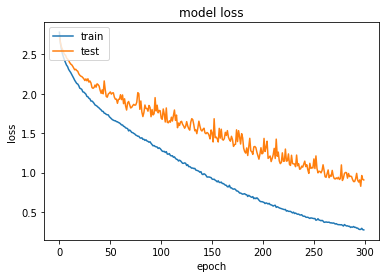

In [ ]:
# Plotting the Train Valid Loss Graph
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model.json
import json
model_json = model.to_json()
with open("/content/drive/My Drive/saved_model/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/saved_model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/saved_model/CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 77.55%
